# Проверка параметрических гипотез

# Библиотеки

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.diagnostic import kstest_normal
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.proportion import binom_test
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.proportion import binom_test, proportions_ztest, proportions_chisquare
from statsmodels.distributions.empirical_distribution import ECDF


# Warmup

## Пример, Kanji, критерий 1

Линия по производству пудры должна обеспечивать средний вес пудры в
упаковке 4 грамма, заявленное стандартное отклонение — 1 грамм.
В ходе инспекции выбрано 9 упаковок, средний вес продукта в них составляет
4.6 грамма.

$H_0$: средний вес пудры в упаковке соответствует норме.

$H_1$: средний вес пудры в упаковке не соответствует норме.

```p=0.0719```

Проверим критерий "вручную":

$Z = \frac{\bar{X}-\mu}{\sigma/\sqrt{n}}.$

$p(Z) = 2 \bigl(1-F(|Z|)\bigr).$

In [2]:
mu = 4
std = 1
n = 9
mean = 4.6

In [3]:
Z = (mean - mu) / (std/ np.sqrt(n))
Z

1.799999999999999

In [4]:
p = 2 * (1 - st.distributions.norm(0, 1).cdf(np.abs(Z)))
p

0.07186063822585176

Просэмплируем похожую выборку и проверим критерий с использованием библиотеки ```statsmodels```

In [5]:
np.random.seed(42)

X = np.random.randn(n) * std + mean
print('mean={}, std={}'.format(np.mean(X), np.std(X)))

mean=5.037561230377956, std=0.7222455089229228


In [6]:
print('Z={}, p={}'.format(*ztest(X, value=mu)))

Z=4.063253133913534, p=4.839349961023562e-05


# Кобзарь, задача 227

Нормируемый уровень дефектных изделий в партии $p_0 = 0.05$. Среди 20 изделий
партии проверка обнаружила 2 дефектных.

$H_0$ : доля дефектных изделий в партии не выше нормы.

$H_1$ : доля дефектных изделий в партии выше нормы.

Для биномиального критерия ```p=0.2642```.

Проверим критерий "вручную":

$T = \sum X_i$

$p(T) = 1 - F(T)$ 

In [7]:
n = 20
p0 = 0.05

T = 2

In [8]:
p = 1 - st.distributions.binom(n, p0).cdf(T)
p

0.07548367378849652

### Проверим критерий с использованием библиотеки ```scipy```.

In [9]:
st.binom_test(T, n, p0, alternative='greater')

0.26416047505615026

### Проверим критерий с использованием библиотеки  ```statsmodels```

In [10]:
binom_test(T, n, p0, alternative='larger')

0.26416047505615026

## Антиконсервативность интервалов доверия

In [11]:
N_exp = 100
n = 40
p_array =  np.arange(0.05, 0.95, 0.01)

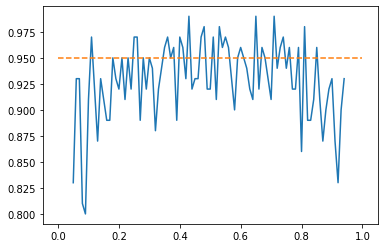

In [12]:
np.random.seed(42)

plot_Y = []
for p in p_array:
    success = 0
    for _ in range(N_exp):
        X = np.random.binomial(n, p)
        left, right = (proportion_confint(X, n))
        if left <= p <= right:
            success += 1.0
    plot_Y.append(success / N_exp)
plt.plot(p_array, plot_Y)
plt.plot([0,1], [0.95, 0.95], ls='--')
plt.show()

In [ ]:
np.random.seed(42)

plot_Y = []
for p in p_array:
    success = 0
    for _ in range(N_exp):
        X = np.random.binomial(n, p)        
        left, right = (proportion_confint(X, n, method='beta'))
        if left <= p <= right:
            success += 1
    plot_Y.append(success / N_exp)
plt.plot(p_array, plot_Y)
plt.plot([0,1], [0.95, 0.95], ls='--')
plt.show()

## Бонд, продолжение

Пусть Бонд выбрал взболтанный мартини в 12 случаев из 16.

Требуется:
1. Проверить гипотезу о равнозначности мартини методами ```binom_test```, ```proportions_chisquare```, 
```proportions_ztest```.


2. Провести симуляцию, построить зависимость pow от истинного значения p для выборок мощностью 5, 10, 20, 100, 1000 для разных методов на уровне значимости 0.05.

3. Провести симуляцию, построить зависимость ошибки первого рода от проверяемого значения $p_0$ при истинном значении p=0.5 при заданой мощности выборки n=10.

### Пункт 1
Проверить гипотезу о равнозначности мартини методами ```binom_test```, ```proportions_chisquare```, 
```proportions_ztest```.

In [23]:
binom_test(12, 16, 0.5), proportions_chisquare(12, 16, 0.5), proportions_ztest(12, 16, 0.5)

(0.076812744140625,
 (4.0, 0.04550026389635857, (array([[12,  4]]), array([[8., 8.]]))),
 (2.3094010767585034, 0.020921335337794014))

### Пункт 2

No handles with labels found to put in legend.


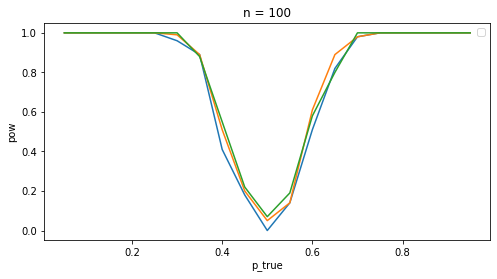

In [79]:
np.random.seed(42)
plt.rcParams['figure.figsize'] = (8.0, 4.0)
plt.legend(loc='best')
plt.xlabel('p_true')
plt.ylabel('pow')

def binom(x_):
    return binom_test(x_, n, 0.5) <= 0.05
def z_test(x_):
    return proportions_ztest(x_, n, 0.5)[1] <= 0.05
def square_test(x_):
    return proportions_chisquare(x_, n, 0.5)[1] <= 0.05

method = dict()
method['binom'] = binom
method['x_test'] = z_test
method['square_test'] = square_test

for name in method:
    X, Y = [], []
    n = 100
    for p in np.arange(0.05, 0.96, 0.05):
        success = 0
        for _ in range(n):
            x_ = np.random.binomial(n, p)
            if method[name](x_):
                success += 1
        X.append(p)
        Y.append(success/100)
    plt.plot(X, Y, label=name)
    plt.title('n = %d' %n)

plt.show()

### Пункт 3

No handles with labels found to put in legend.


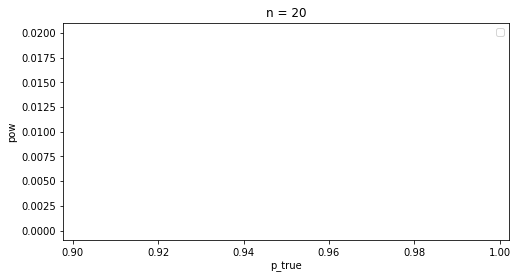

In [72]:
np.random.seed(42)
plt.rcParams['figure.figsize'] = (8.0, 4.0)
plt.legend(loc='best')
plt.xlabel('p_true')
plt.ylabel('pow')

def binom(x_):
    return binom_test(x_, n, 0.5) <= 0.05
def z_test(x_):
    return proportions_ztest(x_, n, 0.5)[1] <= 0.05
def square_test(x_):
    return proportions_chisquare(x_, n, 0.5)[1] <= 0.05

method = dict()
method['binom'] = binom
method['x_test'] = z_test
method['square_test'] = square_test

for name in method:
    X, Y = [], []
    n = 10
    success = 0
    for _ in range(n):
        x_ = np.random.binomial(n, 0.5)
        if method[name](x_):
            success += 1
    X.append(p)
    Y.append(success/100)
    plt.plot(X, Y, label=name)
    plt.title('n = 20')

plt.show()

# Эксперимент Майкельсона
**Michelson A.A. Experimental determination of the velocity of light made at the U.S. Naval Academy, Annapolis. Astronomical Papers, 1, 109-145, 1880.**

Опыты Майкельсона — класс физических экспериментов, исследующих зависимость скорости распространения света от направления.

Проверим данные классического эксперимента Майкельсона по измерению скорости света с помощью вращающегося зеркала, 100 наблюдений на нормальность.

In [81]:
speed = pd.read_csv('https://raw.githubusercontent.com/Intelligent-Systems-Phystech/psad/master/seminars/sem2/data/speed.txt', header=None).values[:, 0]


## Гистограма распределения

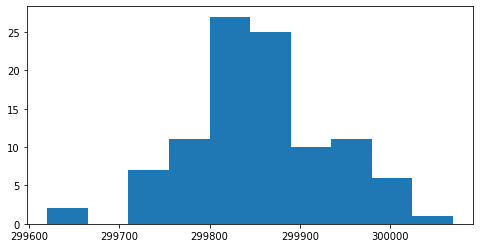

In [84]:
plt.hist(speed)
plt.show()

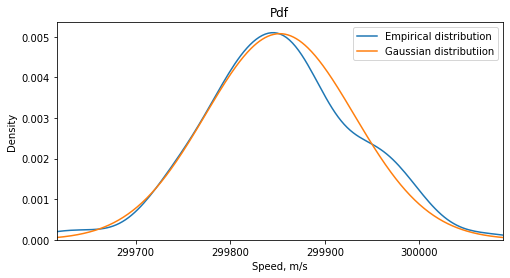

In [86]:
sns.distplot(speed, hist=False, label='Empirical distribution')
x = np.arange(min(speed) - 1000, max(speed) + 1000, 1)
plt.plot(x, st.distributions.norm(np.mean(speed), np.std(speed)).pdf(x), label='Gaussian distributiion')
plt.legend(loc='best')
plt.title('Pdf')
plt.xlabel('Speed, m/s')
plt.ylabel('Density')
plt.xlim(np.mean(speed) - 3 * np.std(speed), np.mean(speed) + 3 * np.std(speed))
plt.show()

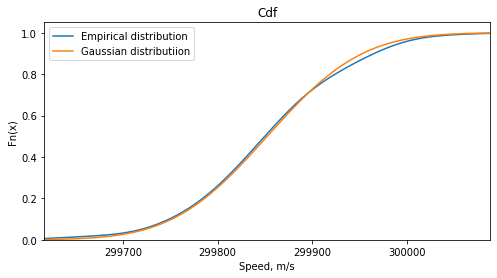

In [87]:
sns.distplot(speed, hist=False, kde_kws=dict(cumulative=True), label='Empirical distribution')
x = np.arange(min(speed) - 1000, max(speed) + 1000, 1)
plt.plot(x, st.distributions.norm(np.mean(speed), np.std(speed)).cdf(x), label='Gaussian distributiion')
plt.legend(loc='best')
plt.title('Cdf')
plt.xlabel('Speed, m/s')
plt.ylabel('Fn(x)')
plt.xlim(np.mean(speed) - 3 * np.std(speed), np.mean(speed) + 3 * np.std(speed))
plt.show()

## Проверка нормальности

### q-q plot

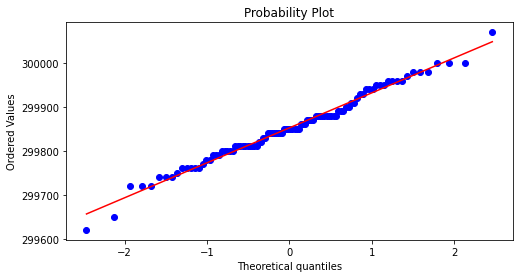

In [88]:
qq_points, qq_line =st.probplot(speed, plot=plt)
plt.show()

### Критерии Колмогорова (Лиллиефорса)

In [89]:
kstest_normal(speed, dist='norm', pvalmethod='approx')

(0.08342437427409632, 0.08289042847559838)

### Критерий Шапиро-Уилка

In [90]:
st.shapiro(speed)

ShapiroResult(statistic=0.9880793690681458, pvalue=0.5140784382820129)

### Критерий Харке-Бера

In [91]:
st.jarque_bera(speed)

Jarque_beraResult(statistic=0.29492498111997556, pvalue=0.8628948044152577)

# Разрушители легенд: тыльная сторона руки

## Часть 1
В 5 серии 13 сезона передачи “Разрушители легенд” проверялась справедливость выражения “know something like the back of one’s hand”. В эксперименте принимало участие 12 испытуемых. Каждому из них были предъявлены 10 фотографий похожих рук разных людей, среди которых они должны были угадать свою.

11 из 12 испытуемых выбрали свою фотографию.

$H_0$: испытуемые выбирают фотографии тыльной стороны руки наугад (p=0.1).

$H_1$: испытуемые выбирают фотографию тыльной стороны своей собственной руки осознанно (p>0.1).



In [93]:
n  = 12
T  = 11
p0 = 0.1


### Точный биномиальный критерий:

In [94]:
binom_test(T, n, p0)

1.0900000000000006e-10

### Z-test

In [95]:
proportions_ztest(T, n, p0)

(10.235766170195031, 1.371056109091178e-24)

### Доверительный интервал Уилсона

In [96]:
proportion_confint(T, n, method='wilson')

(0.646120088858883, 0.9851349055950829)

### Критерий Вальда

In [97]:
p_mle = T / n
D_mle = 1/(-n**2/T+n**2/(n-T))
zw = (p_mle - p0) / (np.sqrt(D_mle))
st.distributions.norm.logcdf(zw)

-4.641014169011439e-21

Ожидаемый ответ: ```~-4.641*10^(-21)```

### Часть 2
Аналогичный эксперимент был проведён с фотографиями ладоней. 7 из 12 испытуемых угадали свою фотографию.

$H_0$: испытуемые выбирают фотографии ладони наугад (p=0.1).

$H_1$: испытуемые выбирают фотографию своей собственной ладони осознанно (p>0.1).

In [98]:
n  = 12
T2  = 7
p0 = 0.1



In [101]:
binom_test(T2, n, p0, 'larger')

5.0180338000000016e-05

Можно ли утверждать, что тыльную сторону руки люди знают лучше, чем ладонь? Сравним результаты экспериментов.
Поскольку это одни и те же испытуемые, выборки связные. 

Но информации о связности нет, поэтому мы вынуждены использовать критерии для независимых выборок. Z-критерий:

In [102]:
P = (T+T2) / (2*n)
Z = (T/n-T2/n)/np.sqrt(P*(1-P)*2/n)
1-st.distributions.norm.cdf(Z)

0.029673219395960015

ожидаемый ответ: ```~0.03```

# Rats
**Weindruch R., Walford R.L. The Retardation of Aging and Disease by Dietary Restriction. Springfield: Charles C. Thomas, 1988.**

In [107]:
rats = pd.read_csv('https://raw.githubusercontent.com/Intelligent-Systems-Phystech/psad/master/seminars/sem2/data/rats.txt', delimiter='\t')
rats.sample(20)

,lifespan,diet
161,733,ad libitum
153,715,ad libitum
112,496,ad libitum
101,1327,restricted
29,893,restricted
137,675,ad libitum
31,901,restricted
109,465,ad libitum
124,621,ad libitum
145,695,ad libitum


In [109]:
x1 = rats.loc[rats['diet'] == 'restricted']['lifespan'].values
x2 = rats.loc[rats['diet'] == 'ad libitum']['lifespan'].values

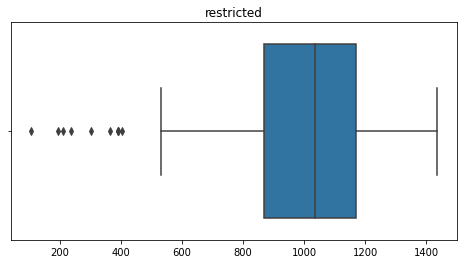

In [110]:
plt.title('restricted')
sns.boxplot(x=x1)
plt.show()

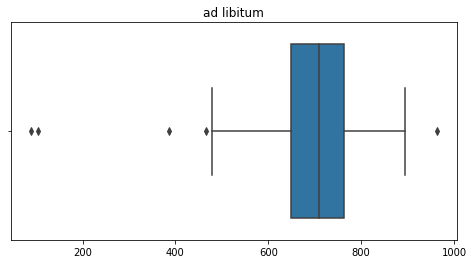

In [111]:
plt.title('ad libitum')
sns.boxplot(x=x2)
plt.show()

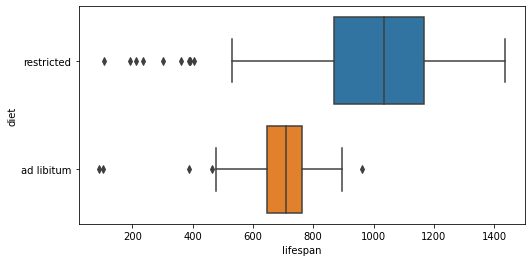

In [112]:
sns.boxplot(x='lifespan', y='diet', data=rats)
plt.show()

## Гистограммы распределений

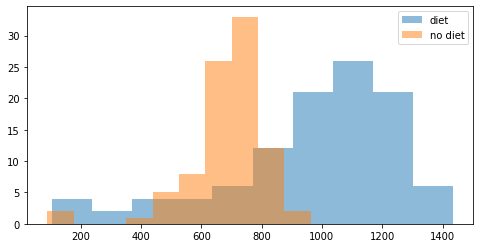

In [116]:
plt.hist(x1, alpha = 0.5, label='diet')
plt.hist(x2, alpha = 0.5, label='no diet')
plt.legend(loc='best')
plt.show()

## Проверка нормальности
$H_0$: каждая из выборок нормальна

$H_1$: нет

### Shapiro

In [118]:
st.shapiro(x1), st.shapiro(x2)

(ShapiroResult(statistic=0.9036345481872559, pvalue=1.1565858812900842e-06),
 ShapiroResult(statistic=0.8444006443023682, pvalue=3.081509092339729e-08))

### q-q plot

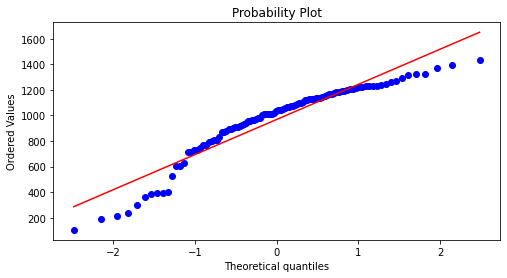

In [119]:
st.probplot(x1, plot=plt)
plt.show()

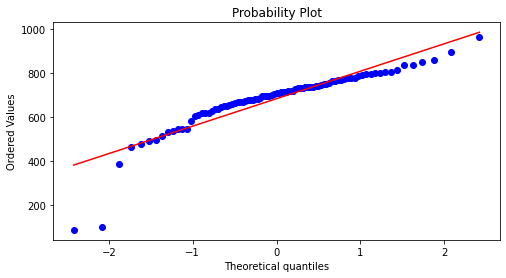

In [120]:
st.probplot(x2, plot=plt)
plt.show()

Попробуем исключить крыс, проживших меньше 400 дней (например, можно предположить, что смерть раньше этого срока вызывается причинами, не связанными с диетой).

In [121]:
x1c = x1[np.where(x1>=400)[0]]
x2c = x2[np.where(x2>=400)[0]]

### Shapiro

In [122]:
st.shapiro(x1c), st.shapiro(x2c)

(ShapiroResult(statistic=0.9738006591796875, pvalue=0.04921640083193779),
 ShapiroResult(statistic=0.9765744209289551, pvalue=0.11983636021614075))

Ожидаемые p-value:
```0.049,  0.119```

Усечённые выборки можно считать практически нормальными.

## Сравнение средних
$H_0$: продолжительность жизни крыс не меняется при ограничении диеты.

$H_1$: крысы на строгой диете живут дольше.



### Усеченные выборки

In [123]:
ttest_ind(x1c, x2c, alternative='larger', usevar='unequal')

(14.527701019046814, 3.941182274101304e-30, 141.33154919379604)

In [124]:
ttest_ind(x1c,x2c, alternative='two-sided', usevar='unequal')

(14.527701019046814, 7.882364548202608e-30, 141.33154919379604)

### Полные выборки:

In [125]:
ttest_ind(x1,x2, alternative='larger', usevar='unequal')

(9.161061040974156, 1.4580405594293205e-16, 154.9404956691433)

In [126]:
ttest_ind(x1,x2, alternative='two-sided', usevar='unequal')

(9.161061040974156, 2.916081118858641e-16, 154.9404956691433)

# Placebo
**Pearson D.A, Santos C.W., Casat C.D., et al. (2004). Treatment effects of methylphenidate on cognitive functioning in children with mental retardation and ADHD. Journal of the American Academy of Child and Adolescent Psychiatry, 43(6), 677–685.**

## Метилфенидат и синдром дефицита внимания

24 умственно отсталых ребёнка с СДВГ в течение недели принимали либо метилфенидат, либо плацебо, а в конце недели проходили тест на способность к подавлению импульсивных поведенческих реакций. На втором этапе плацебо и препарат менялись, после недельного курса каждый испытуемые проходили второй тест.

Каков эффект препарата?

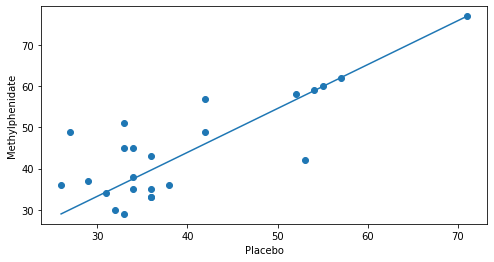

In [127]:
att = pd.read_csv('https://raw.githubusercontent.com/Intelligent-Systems-Phystech/psad/master/seminars/sem2/data/ADHD.txt', sep=' ').values

plt.scatter(att[:, 0], att[:, 1])
plt.xlabel('Placebo')
plt.ylabel('Methylphenidate')
plt.plot([min(att[:,0]), max(att[:,0])], [min(att[:,1]), max(att[:,1])])

plt.show()

### Проверка гипотез
Чтобы использовать критерий Стьюдента для связанных выборок, проверим, нет ли существенных отклонений от нормальности попарных разностей:

### Проверка нормальности

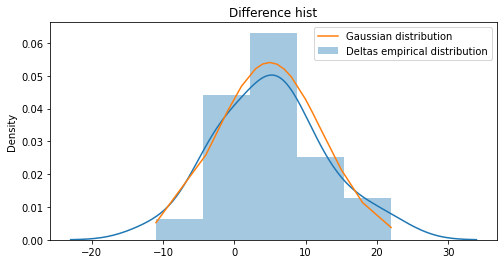

In [128]:
deltas = att[:,1] - att[:,0]
sns.distplot(deltas, label='Deltas empirical distribution')
plt.plot(sorted(deltas), st.distributions.norm(np.mean(deltas), np.std(deltas)).pdf(sorted(deltas)), label='Gaussian distribution')
plt.legend(loc='best')
plt.title('Difference hist')

plt.show()

#### q-q plot

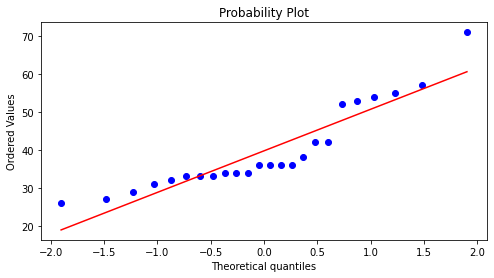

In [136]:
st.probplot(att[:,0], plot=plt)
plt.show()

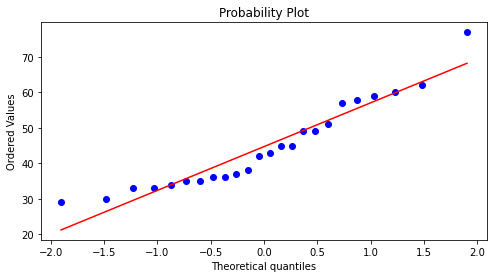

In [139]:
st.probplot(att[:,1], plot=plt)
plt.show()

#### Shapiro

In [140]:
st.shapiro(att[:,0]-att[:, 1])

ShapiroResult(statistic=0.9798052906990051, pvalue=0.8922504186630249)

Следовательно, критерий Стьюдента применим.

### Критерий Стьюдента
$H_0$ - эффекта нет (матожидания равны)

$H_1$ - есть эффект

In [141]:
st.ttest_rel(att[:,0], att[:,1])

Ttest_relResult(statistic=-3.2223624451230406, pvalue=0.003771488176381471)

Если бы у нас не было информации о связях между выборками, пришлось бы применять версию критерия Стьюдента для независимых выборок:



ShapiroResult(statistic=0.8574873208999634, pvalue=0.00302018690854311)


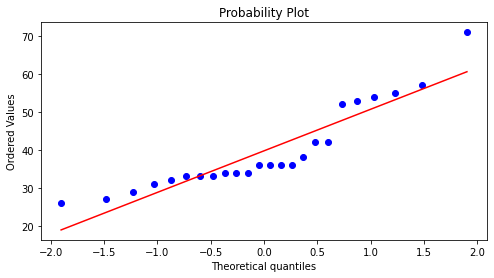

In [143]:
print(st.shapiro(att[:,0]))
st.probplot(att[:,0], plot=plt)
plt.show()


ShapiroResult(statistic=0.9164453148841858, pvalue=0.04876822605729103)


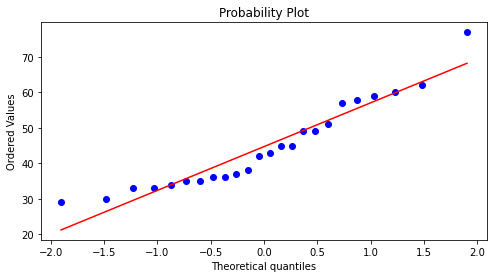

In [146]:
print(st.shapiro(att[:,1]))
st.probplot(att[:,1], plot=plt)
plt.show()

In [147]:
st.ttest_ind(att[:,0], att[:,1])

Ttest_indResult(statistic=-1.452163501815909, pvalue=0.1532433046938409)